In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import set_config
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier, plot_importance
from scipy import stats
from scipy.stats import skew, kurtosis

In [2]:
VER = 28            # VERSION NAME FOR SAVED MODEL FILES
SEED = 42           # TRAIN RANDOM SEED
NAN_VALUE = -127    # FILL NAN VALUE - will fit in int8
FOLDS = 5           # FOLDS PER MODEL
project_dir = "../" # PROJECT FOLDER

## XGBoost Regressor with Randomized Search Hypertuning

We train an XGBoost model using randomized search for hyperparameter tuning.

In [3]:
data_raw_path = "../data-raw"

train_features_csv = f"{data_raw_path}/train_features.csv"
train_outcomes_functional_csv = f"{data_raw_path}/train_outcomes_functional.csv"

test_features_csv = f"{data_raw_path}/test_features.csv"
test_outcomes_csv = f"{data_raw_path}/test_outcomes_Fun_template_update.csv"

metadata_csv = f"{data_raw_path}/metadata.csv"

In [4]:
train_features_df = pd.read_csv(train_features_csv)
train_outcomes_df = pd.read_csv(train_outcomes_functional_csv)

test_features_df = pd.read_csv(test_features_csv)
test_outcomes_df = pd.read_csv(test_outcomes_csv)

metadata_df = pd.read_csv(metadata_csv)

In [5]:
training_df = train_features_df.merge(train_outcomes_df, on="PID", how="inner")
full_training_df = training_df.merge(metadata_df, on="PID", how="inner")

testing_df = test_features_df.merge(test_outcomes_df, on="PID", how="inner")
full_testing_df = testing_df.merge(metadata_df, on="PID", how="inner")

## Subsetting only Week 1 data

In [6]:
target_variables = ["PID", "modben", "age_category", "sexcd", "bmi_category", "srdecc1", "surgcd1", "spcsuc1", "scdecc1", 
                    "hemccd1", "mhpsyccd", "mhneurcd", "mhcardcd", "mhmetacd", "tx1_r", "ais1", "elbfll01", "wrextl01", 
                    "elbexl01", "finfll01", "finabl01", "hipfll01", "kneexl01", "ankdol01", "gretol01", "ankpll01", 
                    "elbflr01", "wrextr01", "elbexr01", "finflr01", "finabr01", "hipflr01", "kneetr01", "ankdor01", 
                    "gretor01", "ankplr01", "c2ltl01", "c3ltl01", "c4ltl01", "c5ltl01", "c6ltl01", "c7ltl01", "c8ltl01", 
                    "t1ltl01", "t2ltl01", "t3ltl01", "t4ltl01", "t5ltl01", "t6ltl01", "t7ltl01", "t8ltl01", "t9ltl01", 
                    "t10ltl01", "t11ltl01", "t12ltl01", "l1ltl01", "l2ltl01", "l3ltl01", "l4ltl01", "l5ltl01", "s1ltl01", 
                    "s2ltl01", "s3ltl01", "s45ltl01", "c2ltr01", "c3ltr01", "c4ltr01", "c5ltr01", "c6ltr01", "c7ltr01", 
                    "c8ltr01", "t1ltr01", "t2ltr01", "t3ltr01", "t4ltr01", "t5ltr01", "t6ltr01", "t7ltr01", "t8ltr01", 
                    "t9ltr01", "t10ltr01", "t11ltr01", "t12ltr01", "l1ltr01", "l2ltr01", "l3ltr01", "l4ltr01", "l5ltr01", 
                    "s1ltr01", "s2ltr01", "s3ltr01", "s45ltr01", "c2ppl01", "c3ppl01", "c4ppl01", "c5ppl01", "c6ppl01", 
                    "c7ppl01", "c8ppl01", "t1ppl01", "t2ppl01", "t3ppl01", "t4ppl01", "t5ppl01", "t6ppl01", "t7ppl01", 
                    "t8ppl01", "t9ppl01", "t10ppl01", "t11ppl01", "t12ppl01", "l1ppl01", "l2ppl01", "l3ppl01", "l4ppl01", 
                    "l5ppl01", "s1ppl01", "s2ppl01", "s3ppl01", "s45ppl01", "c2ppr01", "c3ppr01", "c4ppr01", "c5ppr01", 
                    "c6ppr01", "c7ppr01", "c8ppr01", "t1ppr01", "t2ppr01", "t3ppr01", "t4ppr01", "t5ppr01", "t6ppr01", 
                    "t7ppr01", "t8ppr01", "t9ppr01", "t10ppr01", "t11ppr01", "t12ppr01", "l1ppr01", "l2ppr01", "l3ppr01", 
                    "l4ppr01", "l5ppr01", "s1ppr01", "s2ppr01", "s3ppr01", "s45ppr01"]

In [7]:
training_df = full_training_df[target_variables]
testing_df = full_testing_df[target_variables]

## Feature Engineering

In [8]:
def process_and_feature_engineering(df):
    """
    Perform feature engineering by aggregating numerical and categorical features 
    over the 'PID' identifier. Adds statistical, ratio, trend, and comorbidity-based features.

    Parameters
    ==========
    df (pd.DataFrame): Input DataFrame containing patient-level records with a 'PID' column and features.

    Returns
    =======
    pd.DataFrame: Aggregated DataFrame with engineered features indexed by 'PID'.
    """
    # Fill NA values
    df = df.fillna(NAN_VALUE).copy()

    # Exclude identifier and target from the feature list
    all_cols = [col for col in df.columns if col not in ["PID", "modben"]]

    # Categorical features
    category_feats = ["age_category", "sexcd", "bmi_category", "srdecc1", "surgcd1", "spcsuc1", "scdecc1", 
                      "hemccd1", "mhpsyccd", "mhneurcd", "mhcardcd", "mhmetacd", "tx1_r", "ais1"]

    # Numeric features
    num_feats = [col for col in all_cols if col not in category_feats]

    # --- Custom features before aggregation ---

    # bmi_age_ratio
    if "bmi" in df.columns and "age" in df.columns:
        df["bmi_age_ratio"] = df["bmi"] / (df["age"] + 1)
        num_feats.append("bmi_age_ratio")

    # sexcd_avg_bmi
    if "bmi" in df.columns and "sexcd" in df.columns:
        df["sexcd_avg_bmi"] = df.groupby("sexcd")["bmi"].transform("mean")
        num_feats.append("sexcd_avg_bmi")

    # comorbidity_sum
    comorb_cols = ['mhpsyccd', 'mhneurcd', 'mhcardcd', 'mhmetacd']
    comorb_cols = [col for col in comorb_cols if col in df.columns]
    df["comorbidity_sum"] = df[comorb_cols].sum(axis=1)
    num_feats.append("comorbidity_sum")

    # Surgery complexity
    df["surgery_complexity_score"] = df[["srdecc1", "surgcd1", "spcsuc1", "scdecc1", "hemccd1"]].sum(axis=1)
    num_feats.append("surgery_complexity_score")

    # surgery was decompression only
    df["surgery_was_decompression_only"] = ((df["srdecc1"] == 1) & (df["surgcd1"] == 0)).astype(int)
    category_feats.append("surgery_was_decompression_only")

    # Psych and Neuro overlap
    df["psych_neuro_overlap"] = ((df["mhpsyccd"] == 1) & (df["mhneurcd"] == 1)).astype(int)
    category_feats.append("psych_neuro_overlap")

    # Metabolic and cardiac interactions
    df["metabolic_and_cardiac"] = ((df["mhmetacd"] == 1) & (df["mhcardcd"] == 1)).astype(int)
    category_feats.append("metabolic_and_cardiac")

    # Treatment group and surgery type associations
    df["treated_and_operated"] = ((df["tx1_r"].isin(["D1", "D2"])) & (df["surgcd1"] == 1)).astype(int)
    category_feats.append("treated_and_operated")

    # Age and Sex
    df["age_sex_combo"] = df["age_category"].astype(str) + "_" + df["sexcd"].astype(str)
    category_feats.append("age_sex_combo")
    
    # Surgical decisions in the context of comorbidities
    df["surgery_with_comorbidities"] = ((df["surgcd1"] == 1) & (df["comorbidity_sum"] > 0)).astype(int)
    category_feats.append("surgery_with_comorbidities")
    
    # Unknown history flags
    df["num_unknown_history"] = df[["mhpsyccd", "mhneurcd", "mhcardcd", "mhmetacd"]].apply(lambda row: (row == 9).sum(), axis=1)
    num_feats.append("num_unknown_history")

    # --- Aggregations ---

    # Basic numeric stats
    test_num_agg = df.groupby("PID")[num_feats].agg(['mean', 'std', 'min', 'max', 'last'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]

    # Skewness and kurtosis
    test_num_skew = df.groupby("PID")[num_feats].apply(lambda x: x.skew()).rename(columns=lambda x: f"{x}_skew")
    test_num_kurt = df.groupby("PID")[num_feats].apply(lambda x: x.apply(kurtosis)).rename(columns=lambda x: f"{x}_kurt")
    test_num_skew_kurt = pd.concat([test_num_skew, test_num_kurt], axis=1)

    # Range
    test_num_range = df.groupby("PID")[num_feats].apply(lambda x: x.max() - x.min())
    test_num_range.columns = [f"{col}_range" for col in test_num_range.columns]

    # IQR
    test_num_iqr = df.groupby("PID")[num_feats].apply(lambda x: x.quantile(0.75) - x.quantile(0.25))
    test_num_iqr.columns = [f"{col}_iqr" for col in test_num_iqr.columns]

    # Trend
    def compute_trend(x):
        idx = np.arange(len(x))
        if len(x.dropna()) < 2:
            return np.nan
        return np.polyfit(idx, x.fillna(0), 1)[0]

    test_num_trend = df.groupby("PID")[num_feats].apply(lambda group: group.apply(compute_trend))
    test_num_trend.columns = [f"{col}_trend" for col in test_num_trend.columns]

    # Categorical aggregations
    test_cat_agg = df.groupby("PID")[category_feats].agg(['count', 'last', 'nunique'])
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]

    # Combine everything
    df = pd.concat([
        test_num_agg,
        test_num_skew_kurt,
        test_num_range,
        test_num_iqr,
        test_num_trend,
        test_cat_agg
    ], axis=1)

    del test_num_agg, test_num_skew_kurt, test_num_range, test_num_iqr, test_num_trend, test_cat_agg
    print(f"Shape after engineering: {df.shape}")
    return df

In [9]:
train = process_and_feature_engineering(training_df)
test = process_and_feature_engineering(testing_df)

Shape after engineering: (582, 1410)
Shape after engineering: (118, 1410)


In [10]:
train = train.sort_index().reset_index()
test = test.sort_index().reset_index()

## X and Y Datasets

In [11]:
train = train.merge(train_outcomes_df, on="PID", how="inner")
train = train.drop("time", axis=1)

test = test.merge(test_outcomes_df, on="PID", how="inner")
test = test.drop("time-DELETE THIS COLUMN FOR SUBMISSION", axis=1)

In [12]:
# Ensure we have a category dtype
for col in train.select_dtypes(include='object').columns:
    train[col] = train[col].astype('category')

for col in test.select_dtypes(include='object').columns:
    test[col] = test[col].astype('category')

In [13]:
train = train[train['modben'] != 9.0].copy()
train['modben'] = train['modben'].astype(int) - 1
train.reset_index(drop=True, inplace=True)

In [14]:
x_train = train.drop("modben", axis=1)
y_train = train["modben"]

x_test = test.drop("modben", axis=1)
y_test = test["modben"]

In [15]:
if "PID" in x_train.columns:
    x_train = x_train.drop(columns=["PID"])

if "PID" in x_test.columns:
    pid_test = x_test["PID"].copy()
    x_test = x_test.drop(columns=["PID"])

## Utilities

In [16]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_curve, 
    auc, 
    precision_recall_curve
)
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(y_true, y_pred, title, project_dir, version):
    """
    Evaluate a model using various metrics and generate precision-recall and ROC curves.

    Parameters:
    - y_true (array-like): True labels.
    - y_pred (array-like): Predicted labels or class probabilities.
    - title (str): Title for the evaluation.
    - project_dir (str): Project directory.
    - version (int): Current model version.
    """
    try:
        if len(y_true) != len(y_pred):
            raise ValueError("Mismatched dimensions of y_true and y_pred.")

        accuracy = accuracy_score(y_true, y_pred)
        report = classification_report(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
        recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)
        f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0)

        print(f"\n{title if title else 'Model Evaluation'}")
        print(f"Accuracy: {accuracy:.4f}")
        print("Confusion Matrix:\n", cm)
        print(f"Precision (weighted): {precision:.4f}")
        print(f"Recall (weighted):    {recall:.4f}")
        print(f"F1 Score (weighted):  {f1:.4f}")
        print("Classification Report:\n", report)

        # Optional: Precision-Recall and ROC curves
        # Only works for binary classification or if probabilities are provided for multiclass
        unique_classes = np.unique(y_true)
        if len(unique_classes) == 2:
            if hasattr(y_pred, "shape") and len(y_pred.shape) == 2 and y_pred.shape[1] > 1:
                y_pred_scores = y_pred[:, 1]
            else:
                y_pred_scores = y_pred  # Must be probabilities for PR/ROC

            pr_precision, pr_recall, _ = precision_recall_curve(y_true, y_pred_scores)
            plt.figure()
            plt.plot(pr_recall, pr_precision, color="darkorange", lw=2)
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title(f"{title}: Precision-Recall Curve")
            plt.savefig(f"{project_dir}/{title}_PRC-v{version}.png")

            fpr, tpr, _ = roc_curve(y_true, y_pred_scores)
            roc_auc = auc(fpr, tpr)
            plt.figure()
            plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
            plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"{title}: Receiver Operating Characteristic Curve")
            plt.legend(loc="lower right")
            plt.savefig(f"{project_dir}/{title}_ROC-v{version}.png")
        else:
            print("Skipping PR and ROC curve generation (requires binary classification).")

    except Exception as e:
        print(f"Error during model evaluation: {e}")
        raise

In [17]:
import joblib

def export_model(model, model_name, save_path):
    """
    Export the trained model for serving predictions.

    Parameters:
    - model (Model): Trained model.
    - model_name (str): Name of the model for logging purposes.
    - save_path (str): Path to save the exported model.
    """
    try:
        print(f"Saving model '{model_name}' to '{save_path}'")
        with open(save_path, "wb") as save_file:
            joblib.dump(model, save_file)
        print(f"Model '{model_name}' successfully saved to '{save_path}'")
    except Exception as e:
        print(f"Error during model export for '{model_name}': {e}")
        raise

## Train XGBoost

In [18]:
xgboost_classifier = {
    "colsample_bytree": 0.5,
    "max_depth": 2,
    "min_child_weight": 2,
    "n_estimators": 300,
    "subsample": 0.55,
    "gamma": 10,
    "eta": 0.1
}

In [19]:
xgb_parameters_grid = {
    "n_estimators": stats.randint(max(100, xgboost_classifier["n_estimators"] - 100), xgboost_classifier["n_estimators"] + 200),
    "subsample": stats.uniform(loc=max(0.5, xgboost_classifier["subsample"] - 0.2), scale=0.4),
    "max_depth": stats.randint(max(1, xgboost_classifier["max_depth"] - 1), xgboost_classifier["max_depth"] + 4),
    "colsample_bytree": stats.uniform(loc=max(0.3, xgboost_classifier["colsample_bytree"] - 0.2), scale=0.4),
    "min_child_weight": stats.randint(max(1, xgboost_classifier["min_child_weight"] - 1), xgboost_classifier["min_child_weight"] + 4),
    "gamma": stats.uniform(loc=0, scale=max(10, xgboost_classifier["gamma"])),
    "eta": stats.uniform(loc=0.01, scale=0.3)
}

In [20]:
def train_xgboost(x, y, parameters_grid, version, cross_val=5, scoring="accuracy", 
                  n_jobs=-1, error_score="raise", verbose=10, dir=project_dir):
    """
    Train an XGBoost model using randomized search for hyperparameter tuning.

    Parameters
    ==========
    - x (pd.DataFrame): Input features.
    - y (pd.Series): Labels.
    - parameters_grid (dict): Hyperparameter grid for randomized search.
    - version (int): Current working version.
    - cross_val (int, optional): Number of cross-validation folds. Default is 5.
    - scoring (str, optional): Scoring strategy for cross-validation. Default is "accuracy".
    - n_jobs (int, optional): Number of jobs to run in parallel during cross-validation. Default is -1 (use all processors).
    - error_score (str or numeric, optional): Value to assign to the score if an error occurs in cross-validation. Default is "raise".
    - verbose (int, optional): Verbosity level. Default is 10.
    - dir (str, optional): Directory to save cross-validation results. Default is the current directory.

    Returns
    =======
    - best_params (dict): Best hyperparameters found during the search.
    """
    print(f"Parameters Grid: {parameters_grid}")
    print(f"{cross_val}-fold cross-validation")
    print(f"Scoring strategy: {scoring}")
    print(f"Number of jobs to run in parallel: {n_jobs}")
    print(f"Error score: {error_score}")
    print(f"Verbosity: {verbose}")

    positive_instances = np.sum(y == 1)
    negative_instances = np.sum(y == 0)
    ratio = negative_instances / positive_instances
    print(f"Weight statistics: positive instances={positive_instances}")
    print(f"Weight statistics: negative instances={negative_instances}")
    print(f"Weight statistics: ratio={ratio}")

    xgboost_classifier = XGBClassifier(enable_categorical=True)
    randomized_search = RandomizedSearchCV(
        xgboost_classifier, 
        parameters_grid, 
        cv=cross_val, 
        scoring=scoring, 
        n_jobs=n_jobs, 
        error_score=error_score, 
        verbose=verbose
    )

    randomized_search.fit(x, y)
    best_params = randomized_search.best_params_
    print(f"Best Parameters: {best_params}")

    cv_results_df = pd.DataFrame(randomized_search.cv_results_)
    cv_results_file = f"{dir}/data/xgboost_cv_results-v{version}.csv"

    cv_results_df.to_csv(cv_results_file, index=False)

    return best_params, ratio

In [21]:
from sklearn.feature_selection import SelectFromModel

def drop_zero_importance_features(model, x):
    """
    Drop features with zero importance from the trained model.
    
    Parameters
    ==========
    model : XGBClassifier
        Trained model with feature_importances_.
    x : pd.DataFrame
        Input features.
    
    Returns
    =======
    x_reduced : pd.DataFrame
        DataFrame with only important features.
    """
    selector = SelectFromModel(model, threshold=0, prefit=True)
    selected_features = x.columns[selector.get_support()]
    x_reduced = x[selected_features]
    print(f"Selected {len(selected_features)} features out of {x.shape[1]}")
    return x_reduced, selected_features


In [22]:
def train_xgboost_best(x, y, best_params, ratio, save_drive, version):
    """
    Train an XGBoost model with the best hyperparameters.

    Parameters:
    - x (array-like): Input features.
    - y (array-like): Labels.
    - best_params (dict): Best hyperparameters.
    - version (int): Current working version.

    Returns:
    - final_model: Trained XGBoost model.
    """
    print("Final training with the best hyperparameters.")
    print(f"Best hyperparameter configuration: {best_params}")

    # Input validation
    if not isinstance(x, (np.ndarray, pd.DataFrame)):
        print("Input 'x' must be a numpy array or a pandas DataFrame.")
        raise ValueError("Input 'x' must be a numpy array or a pandas DataFrame.")
    if not isinstance(y, (np.ndarray, pd.Series)):
        print("Input 'y' must be a numpy array or a pandas DataFrame.")
        raise ValueError("Input 'y' must be a numpy array or a pandas Series.")

    # Initialize the model with the best hyperparameters
    final_model = XGBClassifier(**best_params, enable_categorical=True)

    try:
        final_model.fit(x, y)
        print("Final model training completed.")

        print("Getting feature importance..")
        feature_importance = final_model.feature_importances_
        feature_names = x.columns

        feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

        csv_file = f"{save_drive}/xgboost_feature_importance-v{version}.csv"
        feature_importance_df.to_csv(csv_file, index=False)

        print(f"Feature importance saved in CSV file: {csv_file}")

        # Plot and save the top 10 features
        top_10_feature_importance = feature_importance_df.head(10)
        
        plt.barh(top_10_feature_importance['Feature'], top_10_feature_importance['Importance'])
        plt.title("Top 10 Important Features")
        save_plot_file = f"{save_drive}/xgboost_top_10_feature_importance-v{version}.png"
        plt.savefig(save_plot_file, bbox_inches="tight")

        print(f"Top 10 feature importance plot saved in {save_plot_file}")
    except Exception as e:
        print(f"Error during final model training: {e}")
        raise

    return final_model

In [23]:
def test_xgboost(x, y, model, evaluate, project_dir, version):
    try:
        print("Making XGBoost Predictions...")
        predictions = model.predict(x)

        if evaluate:
            print("Evaluating XGBoost Model...")
            evaluate_model(y, predictions, title="XGBoost Test", project_dir=project_dir, version=version)

        return model

    except Exception as e:
        print(f"Error during XGBoost model testing: {e}")
        raise

In [24]:
best_parameters, ratio = train_xgboost(x_train, y_train, parameters_grid=xgb_parameters_grid, version=VER)

Parameters Grid: {'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f36ff06cfd0>, 'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f36ff06eb90>, 'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f36ff06e5f0>, 'colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f36ff06c1f0>, 'min_child_weight': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f36ff06d000>, 'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f36ff06c370>, 'eta': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f36ff06c910>}
5-fold cross-validation
Scoring strategy: accuracy
Number of jobs to run in parallel: -1
Error score: raise
Verbosity: 10
Weight statistics: positive instances=69
Weight statistics: negative instances=277
Weight statistics: ratio=4.0144927536231885
Fitting 5 folds for each of 10 candidates, totalling 50 fits

In [35]:
best_params_v26 = {
    "colsample_bytree": 0.5453095392801284,
    "eta": 0.20120832964550597,
    "gamma": 6.402674847249719,
    "max_depth": 1,
    "min_child_weight": 4,
    "n_estimators": 299,
    "subsample": 0.8549997869017043
}

In [36]:
# Drop zero-importance features
temp_model = XGBClassifier(**best_params_v26, enable_categorical=True) # Using Version 26's best parameters
temp_model.fit(x_train, y_train)
x_train_reduced, selected_features = drop_zero_importance_features(temp_model, x_train)

Selected 1410 features out of 1410


Final training with the best hyperparameters.
Best hyperparameter configuration: {'colsample_bytree': 0.5453095392801284, 'eta': 0.20120832964550597, 'gamma': 6.402674847249719, 'max_depth': 1, 'min_child_weight': 4, 'n_estimators': 299, 'subsample': 0.8549997869017043}
Final model training completed.
Getting feature importance..
Feature importance saved in CSV file: ..//output//xgboost_feature_importance-v28.csv
Top 10 feature importance plot saved in ..//output//xgboost_top_10_feature_importance-v28.png


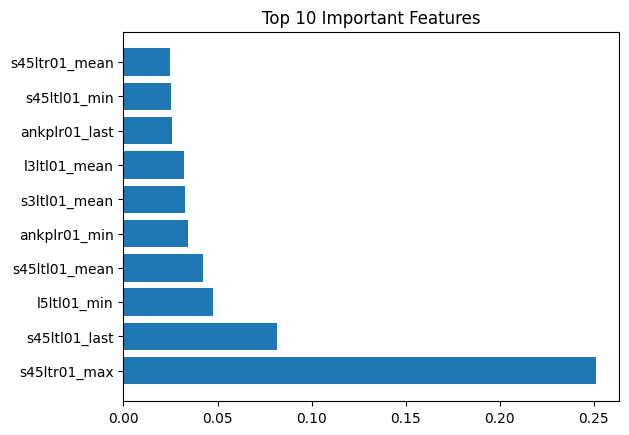

In [37]:
final_model = train_xgboost_best(x_train_reduced, 
                                 y_train, 
                                 best_params=best_params_v26, 
                                 ratio=ratio, 
                                 save_drive=f"{project_dir}/output/", 
                                 version=VER)

In [38]:
export_model(model=final_model,
             model_name=f"XGBoost Model-V{VER}",
             save_path=f"{project_dir}/data/models/xgboost_model-v{VER}.joblib")

Saving model 'XGBoost Model-V28' to '..//data/models/xgboost_model-v28.joblib'
Model 'XGBoost Model-V28' successfully saved to '..//data/models/xgboost_model-v28.joblib'


In [39]:
# Save selected features
pd.Series(selected_features).to_csv(f"{project_dir}/data/models/xgboost_selected_features-v{VER}.csv", index=False)

## Analysis

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

final_model.fit(X_train, y_train)
preds_val = final_model.predict(X_val)

In [47]:
test_xgboost(
    x=X_val,
    y=y_val,
    model=final_model,
    evaluate=True,
    project_dir=project_dir,
    version=VER
)

Making XGBoost Predictions...
Evaluating XGBoost Model...

XGBoost Test
Accuracy: 0.5752
Confusion Matrix:
 [[55  0  0  0  0  0  0]
 [ 9  1  0  0  0  0  0]
 [ 7  0  0  0  2  0  0]
 [ 5  1  0  0  1  0  0]
 [ 2  3  0  0  4  6  1]
 [ 0  1  0  0  5  3  1]
 [ 1  0  0  0  2  1  2]]
Precision (weighted): 0.4472
Recall (weighted):    0.5752
F1 Score (weighted):  0.4962
Classification Report:
               precision    recall  f1-score   support

           0       0.70      1.00      0.82        55
           1       0.17      0.10      0.12        10
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00         7
           4       0.29      0.25      0.27        16
           5       0.30      0.30      0.30        10
           6       0.50      0.33      0.40         6

    accuracy                           0.58       113
   macro avg       0.28      0.28      0.27       113
weighted avg       0.45      0.58      0.50       113

Skipping PR and

/home/carlitos/Documents/Projects/R/kaggle-ASIA_Functional_Track/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/carlitos/Documents/Projects/R/kaggle-ASIA_Functional_Track/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/carlitos/Documents/Projects/R/kaggle-ASIA_Functional_Track/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. U

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5453095392801284, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eta=0.20120832964550597, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=6.402674847249719, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=1,
              max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=299,
              n_jobs=None, ...)

## Predicting on new unseen data

In [40]:
predictions = final_model.predict(x_test)
probabilities = final_model.predict_proba(x_test)

In [41]:
result_df = x_test.copy()
result_df["PID"] = pid_test
result_df["predicted_label"] = predictions
result_df["probability"] = probabilities.max(axis=1)

In [42]:
submission_df = result_df[["PID", "predicted_label"]].copy()
submission_df["predicted_label"] = submission_df["predicted_label"] + 1

In [43]:
submission_df = submission_df.rename(columns={"predicted_label":"modben"})

In [44]:
submission_df.head()

,PID,modben
0,PID_110,1
1,PID_113,2
2,PID_114,6
3,PID_117,1
4,PID_120,7


In [45]:
with open(f"../data/predicted_xgb_v{VER}.csv", "wb") as input_csv:
    submission_df.to_csv(input_csv, index=False)